In [46]:
import librosa
from scipy.fftpack import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import soundfile as sf
import sklearn
import pandas as pd
import os, wave
import pickle

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [47]:
data = '/kaggle/input/covid19-cough-audio-classification/'
file = "metadata_compiled.csv"
df=pd.read_csv(data+file,sep=",")
full_df = df
full_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27545,fff30afc-db62-4408-a585-07ca9a254fcc,2020-11-05T08:26:04.219206+00:00,0.9698,11.109221,40.7,29.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27546,fff3ff61-2387-4139-938b-539db01e6be5,2020-06-28T21:28:21.530881+00:00,0.5257,43.932829,51.6,-0.2,NaN,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,2020-04-10T05:10:36.787070+00:00,0.1945,27.702036,-39.0,-68.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27548,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,2020-04-13T18:58:26.954663+00:00,0.0243,8.825849,41.0,28.8,50.0,male,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
Covid_data = pd.DataFrame()
Covid_data['uuid'] = df['uuid']
Covid_data['status'] = df['status']
Covid_data = Covid_data.dropna()
#Covid_data

In [49]:
df = Covid_data[Covid_data['status']=="healthy"]
remove_n = 4000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
#df_subset

'''
All of the coughs in the public database that were labeled as COVID-19 
among the four experts were subsequently pooled together and analyzed for trends in the attributes of the cough recordings. 
The vast majority of coughs do not exhibit audible dyspnea (93.72%), wheezing (92.43%), stridor (98.71%), choking (99.20%), or nasal congestion (99.03%). 
Additionally, 86.96% of COVID-19-labeled coughs are annotated as dry, which is consistent with literature stating that a dry cough is a common COVID-19 symptom5,30. 
Finally, 83.58% of these coughs are labeled as mild. These commonalities among COVID-19 labeled coughs reflect the consistency of the database.
'''

'\nAll of the coughs in the public database that were labeled as COVID-19 \namong the four experts were subsequently pooled together and analyzed for trends in the attributes of the cough recordings. \nThe vast majority of coughs do not exhibit audible dyspnea (93.72%), wheezing (92.43%), stridor (98.71%), choking (99.20%), or nasal congestion (99.03%). \nAdditionally, 86.96% of COVID-19-labeled coughs are annotated as dry, which is consistent with literature stating that a dry cough is a common COVID-19 symptom5,30. \nFinally, 83.58% of these coughs are labeled as mild. These commonalities among COVID-19 labeled coughs reflect the consistency of the database.\n'

In [50]:
Covid_data  = pd.concat([Covid_data, df_subset])
Covid_data = Covid_data.drop_duplicates(keep=False)
#Covid_data

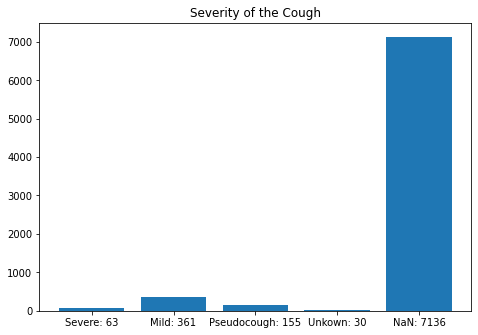

In [51]:
# Create a new dataframe for the severity column
severity_data = pd.DataFrame()
severity_data['uuid'] = full_df['uuid']
severity_data['severity_4'] = full_df['severity_4']
severity_data.dropna()
severity_data = pd.merge(Covid_data, severity_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
#[nan 'mild' 'severe' 'pseudocough' 'unknown']
mild_severity_data = severity_data[severity_data['severity_4'] == 'mild']
mild_severity_index = mild_severity_data.index
mild_severity_count = len(mild_severity_index)

severe_severity_data = severity_data[severity_data['severity_4'] == 'severe']
severe_severity_index = severe_severity_data.index
severe_severity_count = len(severe_severity_index)

psuedo_severity_data = severity_data[severity_data['severity_4'] == 'pseudocough']
psuedo_severity_index = psuedo_severity_data.index
psuedo_severity_count = len(psuedo_severity_index)

unknown_severity_data = severity_data[severity_data['severity_4'] == 'unknown']
unknown_severity_index = unknown_severity_data.index
unknown_severity_count = len(unknown_severity_index)

nullseverity_data = severity_data[severity_data['severity_4'].isna()]
nullseverity_index = nullseverity_data.index
nullseverity_count = len(nullseverity_index)

# Plot the severity count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Severe: ' + str(severe_severity_count), 
     'Mild: ' + str(mild_severity_count), 
     'Pseudocough: ' + str(psuedo_severity_count),
     'Unkown: ' + str(unknown_severity_count), 
     'NaN: ' + str(nullseverity_count)]
y = [severe_severity_count, mild_severity_count, psuedo_severity_count, unknown_severity_count, nullseverity_count]
ax.bar(x,y)
plt.title("Severity of the Cough")
plt.show()

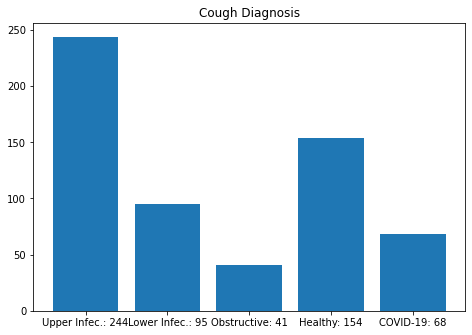

In [52]:
# Create a new dataframe for the diagnosis column
diagnosis_data = pd.DataFrame()
diagnosis_data['uuid'] = full_df['uuid']
diagnosis_data['diagnosis_4'] = full_df['diagnosis_4']
diagnosis_data.dropna()
diagnosis_data = pd.merge(Covid_data, diagnosis_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
#[nan 'upper_infection' 'obstructive_disease' 'lower_infection' 'healthy_cough' 'COVID-19']
upper_diag_data = diagnosis_data[diagnosis_data['diagnosis_4'] == 'upper_infection']
upper_diag_index = upper_diag_data.index
upper_diag_count = len(upper_diag_index)

obstructive_diag_data = diagnosis_data[diagnosis_data['diagnosis_4'] == 'obstructive_disease']
obstructive_diag_index = obstructive_diag_data.index
obstructive_diag_count = len(obstructive_diag_index)

lower_diag_data = diagnosis_data[diagnosis_data['diagnosis_4'] == 'lower_infection']
lower_diag_index = lower_diag_data.index
lower_diag_count = len(lower_diag_index)

healthy_diag_data = diagnosis_data[diagnosis_data['diagnosis_4'] == 'healthy_cough']
healthy_diag_index = healthy_diag_data.index
healthy_diag_count = len(healthy_diag_index)

COVID_diag_data = diagnosis_data[diagnosis_data['diagnosis_4'] == 'COVID-19']
COVID_diag_index = COVID_diag_data.index
COVID_diag_count = len(COVID_diag_index)

nulldiag_data = diagnosis_data[diagnosis_data['diagnosis_4'].isna()]
nulldiag_index = nulldiag_data.index
nulldiag_count = len(nulldiag_index)

# Plot the diagnosis count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Upper Infec.: ' + str(upper_diag_count),
     'Lower Infec.: ' + str(lower_diag_count),
     'Obstructive: ' + str(obstructive_diag_count),
     'Healthy: ' + str(healthy_diag_count),
     'COVID-19: ' + str(COVID_diag_count)]
y = [upper_diag_count, lower_diag_count, obstructive_diag_count, healthy_diag_count, COVID_diag_count]
ax.bar(x,y)
plt.title("Cough Diagnosis")
plt.show()

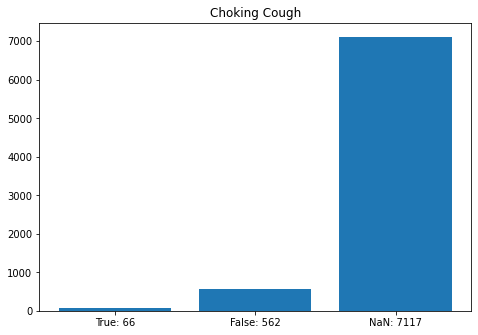

In [53]:
# Create a new dataframe for the congestion column
congestion_data = pd.DataFrame()
congestion_data['uuid'] = full_df['uuid']
congestion_data['congestion_4'] = full_df['congestion_4']
congestion_data.dropna()
congestion_data = pd.merge(Covid_data, congestion_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
truecongestion_data = congestion_data[congestion_data['congestion_4'] == True]
truecongestion_index = truecongestion_data.index
truecongestion_count = len(truecongestion_index)

falsecongestion_data = congestion_data[congestion_data['congestion_4'] == False]
falsecongestion_index = falsecongestion_data.index
falsecongestion_count = len(falsecongestion_index)

nullcongestion_data = congestion_data[congestion_data['congestion_4'].isna()]
nullcongestion_index = nullcongestion_data.index
nullcongestion_count = len(nullcongestion_index)

# Plot the diagnosis count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truecongestion_count), 'False: ' + str(falsecongestion_count), 'NaN: ' + str(nullcongestion_count)]
y = [truecongestion_count, falsecongestion_count, nullcongestion_count]
ax.bar(x,y)
plt.title("Choking Cough")
plt.show()

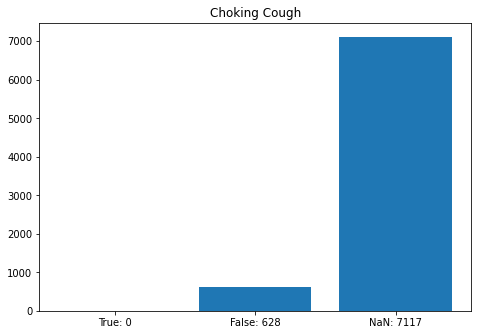

In [54]:
# Create a new dataframe for the choking column
choking_data = pd.DataFrame()
choking_data['uuid'] = full_df['uuid']
choking_data['choking_4'] = full_df['choking_4']
choking_data.dropna()
choking_data = pd.merge(Covid_data, choking_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
truechoking_data = choking_data[choking_data['choking_4'] == True]
truechoking_index = truechoking_data.index
truechoking_count = len(truechoking_index)

falsechoking_data = choking_data[choking_data['choking_4'] == False]
falsechoking_index = falsechoking_data.index
falsechoking_count = len(falsechoking_index)

nullchoking_data = choking_data[choking_data['choking_4'].isna()]
nullchoking_index = nullchoking_data.index
nullchoking_count = len(nullchoking_index)

# Plot the choking count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truechoking_count), 'False: ' + str(falsechoking_count), 'NaN: ' + str(nullchoking_count)]
y = [truechoking_count, falsechoking_count, nullchoking_count]
ax.bar(x,y)
plt.title("Choking Cough")
plt.show()

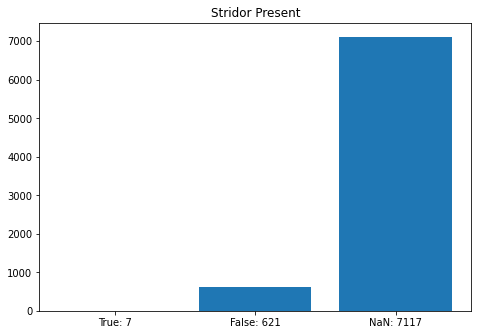

In [55]:
# Create a new dataframe for the stridor column
stridor_data = pd.DataFrame()
stridor_data['uuid'] = full_df['uuid']
stridor_data['stridor_4'] = full_df['stridor_4']
stridor_data.dropna()
stridor_data = pd.merge(Covid_data, stridor_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
truestridor_data = stridor_data[stridor_data['stridor_4'] == True]
truestridor_index = truestridor_data.index
truestridor_count = len(truestridor_index)

falsestridor_data = stridor_data[stridor_data['stridor_4'] == False]
falsestridor_index = falsestridor_data.index
falsestridor_count = len(falsestridor_index)

nullstridor_data = stridor_data[stridor_data['stridor_4'].isna()]
nullstridor_index = nullstridor_data.index
nullstridor_count = len(nullstridor_index)

# Plot the stridor count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truestridor_count), 'False: ' + str(falsestridor_count), 'NaN: ' + str(nullstridor_count)]
y = [truestridor_count, falsestridor_count, nullstridor_count]
ax.bar(x,y)
plt.title("Stridor Present")
plt.show()

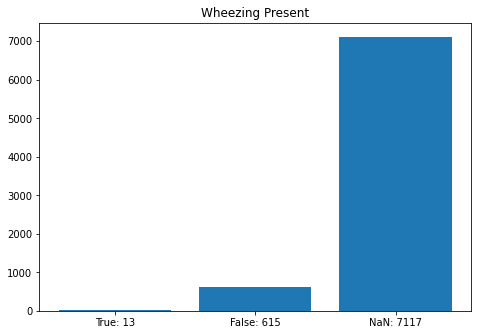

In [56]:
# Create a new dataframe for the wheezing column
wheezing_data = pd.DataFrame()
wheezing_data['uuid'] = full_df['uuid']
wheezing_data['wheezing_4'] = full_df['wheezing_4']
wheezing_data.dropna()
wheezing_data = pd.merge(Covid_data, wheezing_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
truewheeze_data = wheezing_data[wheezing_data['wheezing_4'] == True]
truewheeze_index = truewheeze_data.index
truewheeze_count = len(truewheeze_index)

falsewheeze_data = wheezing_data[wheezing_data['wheezing_4'] == False]
falsewheeze_index = falsewheeze_data.index
falsewheeze_count = len(falsewheeze_index)

nullwheeze_data = wheezing_data[wheezing_data['wheezing_4'].isna()]
nullwheeze_index = nullwheeze_data.index
nullwheeze_count = len(nullwheeze_index)

# Plot the wheeze count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truewheeze_count), 'False: ' + str(falsewheeze_count), 'NaN: ' + str(nullwheeze_count)]
y = [truewheeze_count, falsewheeze_count, nullwheeze_count]
ax.bar(x,y)
plt.title("Wheezing Present")
plt.show()

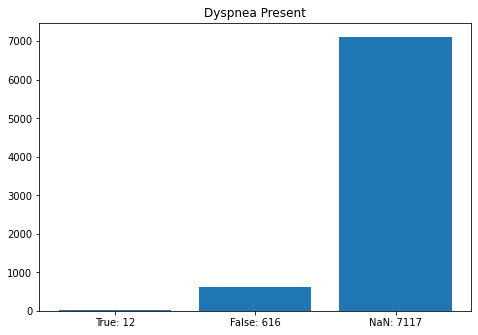

In [57]:
# Create a new dataframe for the dyspnea column
dyspnea_data = pd.DataFrame()
dyspnea_data['uuid'] = full_df['uuid']
dyspnea_data['dyspnea_4'] = full_df['dyspnea_4']
dyspnea_data.dropna()
dyspnea_data = pd.merge(Covid_data, dyspnea_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
truedys_data = dyspnea_data[dyspnea_data['dyspnea_4'] == True]
truedys_index = truedys_data.index
truedys_count = len(truedys_index)

falsedys_data = dyspnea_data[dyspnea_data['dyspnea_4'] == False]
falsedys_index = falsedys_data.index
falsedys_count = len(falsedys_index)

nulldys_data = dyspnea_data[dyspnea_data['dyspnea_4'].isna()]
nulldys_index = nulldys_data.index
nulldys_count = len(nulldys_index)

# Plot the dyspnea count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truedys_count), 'False: ' + str(falsedys_count), 'NaN: ' + str(nulldys_count)]
y = [truedys_count, falsedys_count, nulldys_count]
ax.bar(x,y)
plt.title("Dyspnea Present")
plt.show()

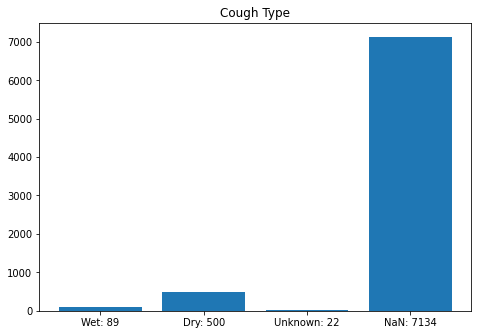

In [58]:
# Create a new dataframe for the cough type column
coughtype_data = pd.DataFrame()
coughtype_data['uuid'] = full_df['uuid']
coughtype_data['cough_type_4'] = full_df['cough_type_4']
coughtype_data.dropna()
coughtype_data = pd.merge(Covid_data, coughtype_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
wetcough_data = coughtype_data[coughtype_data['cough_type_4'] == 'wet']
wetcough_index = wetcough_data.index
wetcough_count = len(wetcough_index)

drycough_data = coughtype_data[coughtype_data['cough_type_4'] == 'dry']
drycough_index = drycough_data.index
drycough_count = len(drycough_index)

unknowncough_data = coughtype_data[coughtype_data['cough_type_4'] == 'unknown']
unknowncough_index = unknowncough_data.index
unknowncough_count = len(unknowncough_index)

nullcough_data = coughtype_data[coughtype_data['cough_type_4'].isna()]
nullcough_index = nullcough_data.index
nullcough_count = len(nullcough_index)

# Plot the cough type count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Wet: ' + str(wetcough_count), 'Dry: ' + str(drycough_count), 'Unknown: ' + str(unknowncough_count), 'NaN: ' + str(nullcough_count)]
y = [wetcough_count, drycough_count, unknowncough_count, nullcough_count]
ax.bar(x,y)
plt.title("Cough Type")
plt.show()

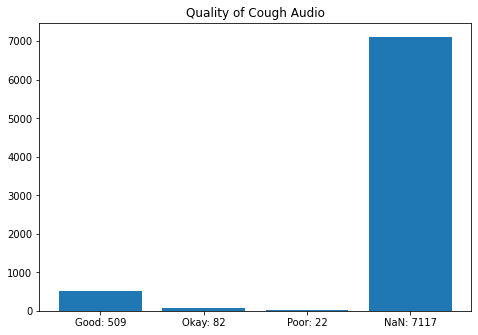

In [59]:
# Create a new dataframe for the quality column
quality_data = pd.DataFrame()
quality_data['uuid'] = full_df['uuid']
quality_data['quality_4'] = full_df['quality_4']
quality_data.dropna()
quality_data = pd.merge(Covid_data, quality_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
poorquality_data = quality_data[quality_data['quality_4'] == 'poor']
poorquality_index = poorquality_data.index
poorquality_count = len(poorquality_index)

okquality_data = quality_data[quality_data['quality_4'] == 'ok']
okquality_index = okquality_data.index
okquality_count = len(okquality_index)

goodquality_data = quality_data[quality_data['quality_4'] == 'good']
goodquality_index = goodquality_data.index
goodquality_count = len(goodquality_index)

nullquality_data = quality_data[quality_data['quality_4'].isna()]
nullquality_index = nullquality_data.index
nullquality_count = len(nullquality_index)

# Plot the quality count of each category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Good: ' + str(goodquality_count), 'Okay: ' + str(okquality_count), 'Poor: ' + str(poorquality_count), 'NaN: ' + str(nullquality_count)]
y = [goodquality_count, okquality_count, poorquality_count, nullquality_count]
ax.bar(x,y)
plt.title("Quality of Cough Audio")
plt.show()

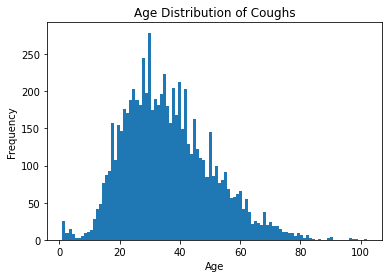

In [60]:
# Create a new dataframe to count the number of people at each age
age_data = pd.DataFrame()
age_data['uuid'] = full_df['uuid']
age_data['age'] = full_df['age']
age_data.dropna()
age_data = pd.merge(Covid_data, age_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Plot the count of people at each age, separated by 100 bins
plt.hist(age_data['age'], bins = 100)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Coughs')
plt.show()

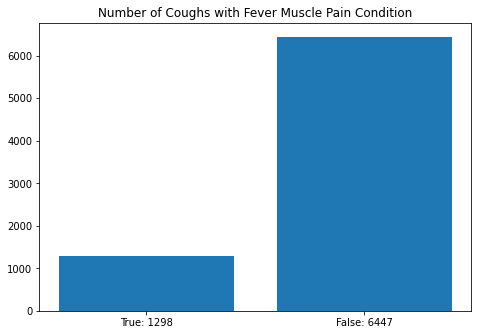

In [61]:
# Create a new dataframe for the fever muscle pain column
fevermuscle_data = pd.DataFrame()
fevermuscle_data['uuid'] = full_df['uuid']
fevermuscle_data['fever_muscle_pain'] = full_df['fever_muscle_pain']
fevermuscle_data.dropna()
fevermuscle_data = pd.merge(Covid_data, fevermuscle_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)
fevermuscle_data

# Extract, count, and categorize each entry
truepain_data = fevermuscle_data[fevermuscle_data['fever_muscle_pain'] == True]
truepain_index = truepain_data.index
truepain_count = len(truepain_index)

falsepain_data = fevermuscle_data[fevermuscle_data['fever_muscle_pain'] == False]
falsepain_index = falsepain_data.index
falsepain_count = len(falsepain_index)

# Plot the number of people with fever muscle pain
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(truepain_count), 'False: ' + str(falsepain_count)]
y = [truepain_count, falsepain_count]
ax.bar(x,y)
plt.title("Number of Coughs with Fever Muscle Pain Condition")
plt.show()

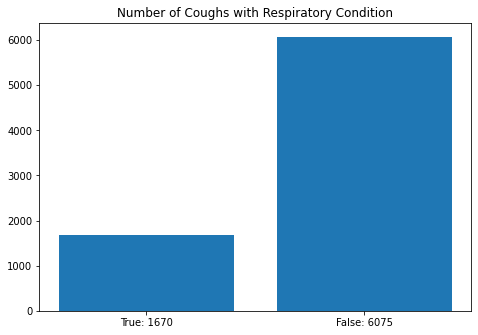

In [62]:
# Create a new dataframe for the respiratory conditions column
respiratory_data = pd.DataFrame()
respiratory_data['uuid'] = full_df['uuid']
respiratory_data['respiratory_condition'] = full_df['respiratory_condition']
respiratory_data.dropna()
respiratory_data = pd.merge(Covid_data, respiratory_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
trueresp_data = respiratory_data[respiratory_data['respiratory_condition'] == True]
trueresp_index = trueresp_data.index
trueresp_count = len(trueresp_index)

falseresp_data = respiratory_data[respiratory_data['respiratory_condition'] == False]
falseresp_index = falseresp_data.index
falseresp_count = len(falseresp_index)

'''
nullresp_data = respiratory_data[respiratory_data['respiratory_condition'].isna()]
nullresp_index = nullresp_data.index
nullresp_count = len(nullresp_index)
'''

# Plot the number of people with respiratory condition
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['True: ' + str(trueresp_count), 'False: ' + str(falseresp_count)]
y = [trueresp_count, falseresp_count]
ax.bar(x,y)
plt.title("Number of Coughs with Respiratory Condition")
plt.show()

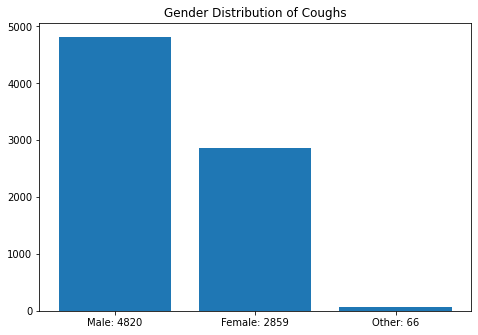

In [63]:
# Create a new dataframe for the gender column
gender_data = pd.DataFrame()
gender_data['uuid'] = full_df['uuid']
gender_data['gender'] = full_df['gender']
gender_data.dropna()
gender_data = pd.merge(Covid_data, gender_data, left_on = 'uuid', right_on = 'uuid').drop('status', axis = 1)

# Extract, count, and categorize each entry
male_data = gender_data[gender_data['gender'] == 'male']
male_index = male_data.index
male_count = len(male_index)

female_data = gender_data[gender_data['gender'] == 'female']
female_index = female_data.index
female_count = len(female_index)

othergender_data = gender_data[gender_data['gender'] == 'other']
othergender_index = othergender_data.index
othergender_count = len(othergender_index)

# Plot the number of people in each gender
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Male: ' + str(male_count), 'Female: ' + str(female_count), 'Other: ' + str(othergender_count)]
y = [male_count, female_count, othergender_count]
ax.bar(x,y)
plt.title("Gender Distribution of Coughs")
plt.show()

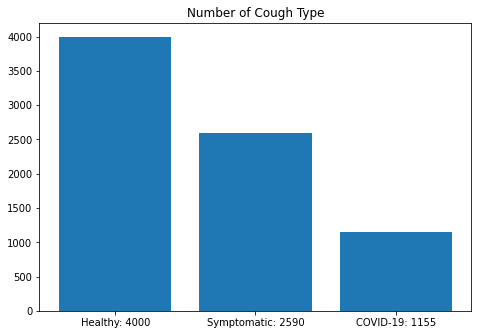

In [64]:
# Healthy vs. Non Healthy
# Create a new dataframe for the status column
healthy_cough = Covid_data[Covid_data['status'] == 'healthy']
h_index = healthy_cough.index
h_count = len(h_index)

# Extract, count, and categorize each entry
symptomatic_cough = Covid_data[Covid_data['status'] == 'symptomatic']
s_index = symptomatic_cough.index
s_count = len(s_index)

covid_cough = Covid_data[Covid_data['status'] == 'COVID-19']
c_index = covid_cough.index
c_count = len(c_index)

# Plot the number of people in each status category
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(h_count), 'Symptomatic: ' + str(s_count), 'COVID-19: ' + str(c_count)]
y = [h_count, s_count, c_count]
ax.bar(x,y)
plt.title("Number of Cough Type")
plt.show()